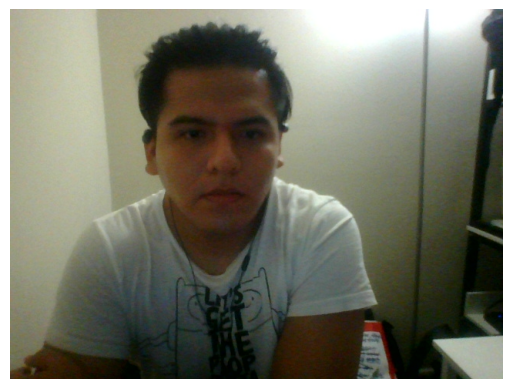

In [2]:
import cv2
import matplotlib.pyplot as plt

# Initialize webcam
video_capture = cv2.VideoCapture(0)

# Capture a single frame from the webcam
ret, frame = video_capture.read()

# Convert image from BGR to RGB for displaying with matplotlib
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the captured image
plt.imshow(rgb_frame)
plt.axis('off')
plt.show()

# Release the webcam
video_capture.release()

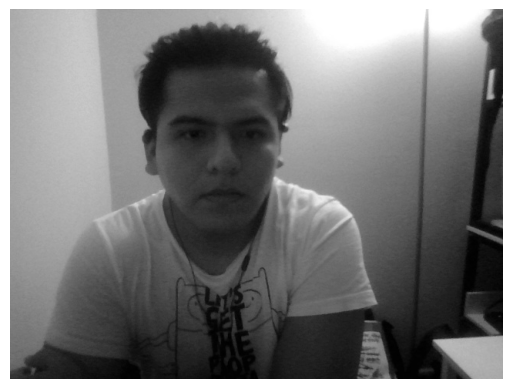

In [3]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_frame, cmap='gray')
plt.axis('off')
plt.show()


In [4]:
resized_frame = cv2.resize(gray_frame, (300, 300))  # Resize image


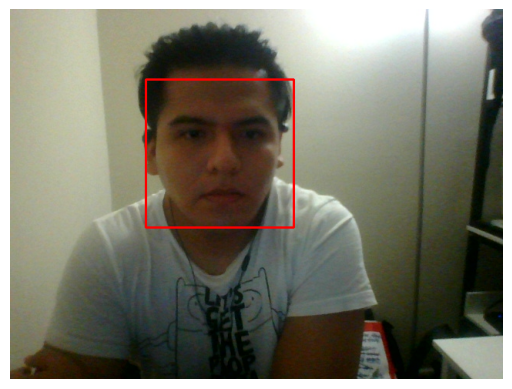

In [5]:
# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces
faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(rgb_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image with rectangles
plt.imshow(rgb_frame)
plt.axis('off')
plt.show()


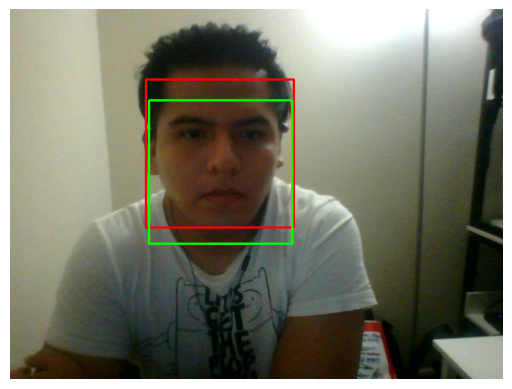

In [6]:
import face_recognition

# Find all face locations in the image
face_locations = face_recognition.face_locations(rgb_frame)

for (top, right, bottom, left) in face_locations:
    cv2.rectangle(rgb_frame, (left, top), (right, bottom), (0, 255, 0), 2)

plt.imshow(rgb_frame)
plt.axis('off')
plt.show()


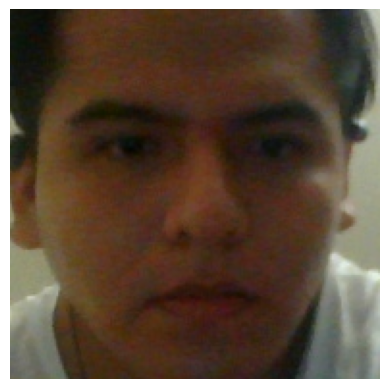

In [7]:
face_counter = 0
for (x, y, w, h) in faces:
    face_img = frame[y:y+h, x:x+w]
    face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    plt.imshow(face_img_rgb)
    plt.axis('off')
    plt.show()
    
    # Save the face image
    cv2.imwrite(f"face_{face_counter}.jpg", face_img)
    face_counter += 1


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset
dataset_path = "grouped_faces"

# Data augmentation generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,  # Increase zoom range
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    fill_mode='nearest',
    validation_split=0.2
)

# Load the training data with augmentation
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load the validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1115 images belonging to 5 classes.
Found 275 images belonging to 5 classes.


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load the pre-trained VGG16 model (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers, unfreeze the last few layers to allow fine-tuning
for layer in base_model.layers[:-10]:  # Freeze more layers
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(5, activation='softmax')(x)  # 5 output categories

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/20


C:\Users\jmarc\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.2132 - loss: 1.7524 - val_accuracy: 0.2227 - val_loss: 1.6010
Epoch 2/20
 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.2500 - loss: 1.6024

C:\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.2500 - loss: 1.6024 - val_accuracy: 0.3684 - val_loss: 1.5569
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.2260 - loss: 1.5963 - val_accuracy: 0.2422 - val_loss: 1.5935
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.4375 - loss: 1.5796 - val_accuracy: 0.2105 - val_loss: 1.5997
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.2622 - loss: 1.5888 - val_accuracy: 0.2461 - val_loss: 1.5893
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.2812 - loss: 1.5739 - val_accuracy: 0.1579 - val_loss: 1.5768
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.2369 - loss: 1.5852 - val_accuracy: 0.2422 - val_loss: 1.5837
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1250 - loss: 1.5901 - val_accuracy: 0.2632 - val_loss: 1.5653
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.2229 - loss: 1.5953 - val_accuracy: 0.2383 - val_loss: 1.

In [12]:
model.save('cowboy_classifier.h5')
